In [1]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import neuralforecast as nf
from neuralforecast.models import NHITS

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-10-07 14:09:23,529	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-07 14:09:24,009	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


/kaggle/input/gold-price-and-s-and-p500-index/EURUSD_HistoricalData_2019-2024.csv
/kaggle/input/gold-price-and-s-and-p500-index/SPX_HistoricalData_2014-2024.csv
/kaggle/input/gold-price-and-s-and-p500-index/USDJPY_HistoricalData_2019-2024.csv
/kaggle/input/gold-price-and-s-and-p500-index/GoldCMX_HistoricalData_2014-2024.csv


# Data preparation

In [3]:
gold = pd.read_csv('/kaggle/input/gold-price-and-s-and-p500-index/GoldCMX_HistoricalData_2014-2024.csv', parse_dates=['Date'])
gold.sort_values('Date', inplace=True, ignore_index=True)
gold = gold.loc[gold.Date.dt.year >= 2020]
gold = gold.reset_index()
print(gold.shape)
gold.head()

(1193, 7)


,index,Date,Close/Last,Volume,Open,High,Low
0,1336,2020-01-02,1528.1,257867.0,1521.0,1534.0,1519.7
1,1337,2020-01-03,1549.2,107.0,1530.1,1552.7,1530.1
2,1338,2020-01-06,1568.8,539023.0,1562.7,1590.9,1562.3
3,1339,2020-01-07,1574.3,418145.0,1567.4,1579.2,1557.0
4,1340,2020-01-08,1560.2,787217.0,1556.7,1563.8,1556.5


In [4]:
spx = pd.read_csv('/kaggle/input/gold-price-and-s-and-p500-index/SPX_HistoricalData_2014-2024.csv', parse_dates=['Date'])
spx.sort_values('Date', inplace=True, ignore_index=True)
spx = spx.loc[spx.Date.dt.year >= 2020]
spx = spx.reset_index()
print(spx.shape)
spx.head()

(1193, 6)


,index,Date,Close/Last,Open,High,Low
0,1335,2020-01-02,3257.85,3244.67,3258.14,3235.53
1,1336,2020-01-03,3234.85,3226.36,3246.15,3222.34
2,1337,2020-01-06,3246.28,3217.55,3246.84,3214.64
3,1338,2020-01-07,3237.18,3241.86,3244.91,3232.43
4,1339,2020-01-08,3253.05,3238.59,3267.07,3236.67


In [5]:
eur = pd.read_csv('/kaggle/input/gold-price-and-s-and-p500-index/EURUSD_HistoricalData_2019-2024.csv', parse_dates=['Date'])
eur.sort_values('Date', inplace=True, ignore_index=True)
eur.head()

,Date,Close/Last,Volume,Open,High,Low
0,2019-03-08,1.1243,NaN,1.1243,1.1246,1.1185
1,2019-03-10,1.1231,NaN,1.1238,1.1239,1.1231
2,2019-03-11,1.1247,NaN,1.1247,1.1255,1.1244
3,2019-03-12,1.1286,NaN,1.1286,1.1292,1.1284
4,2019-03-13,1.1305,NaN,1.1286,1.1318,1.1278


In [6]:
set(spx.Date).difference(set(eur.loc[eur.Date.isin(spx.Date), 'Date']))

{Timestamp('2022-03-04 00:00:00'),
 Timestamp('2023-08-11 00:00:00'),
 Timestamp('2023-08-14 00:00:00'),
 Timestamp('2023-08-15 00:00:00'),
 Timestamp('2023-08-16 00:00:00'),
 Timestamp('2023-08-17 00:00:00'),
 Timestamp('2023-08-18 00:00:00'),
 Timestamp('2023-08-21 00:00:00'),
 Timestamp('2023-08-22 00:00:00'),
 Timestamp('2023-08-23 00:00:00'),
 Timestamp('2023-08-24 00:00:00'),
 Timestamp('2023-08-25 00:00:00'),
 Timestamp('2023-08-28 00:00:00'),
 Timestamp('2023-08-29 00:00:00'),
 Timestamp('2023-08-30 00:00:00'),
 Timestamp('2023-08-31 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-09-05 00:00:00'),
 Timestamp('2023-09-06 00:00:00'),
 Timestamp('2023-09-07 00:00:00'),
 Timestamp('2023-09-08 00:00:00'),
 Timestamp('2023-09-11 00:00:00'),
 Timestamp('2023-09-12 00:00:00'),
 Timestamp('2023-09-13 00:00:00'),
 Timestamp('2023-09-14 00:00:00'),
 Timestamp('2023-09-15 00:00:00'),
 Timestamp('2023-09-18 00:00:00'),
 Timestamp('2023-09-19 00:00:00'),
 Timestamp('2023-09-

In [7]:
eur = pd.merge(spx, eur, how='left', on='Date', suffixes=('_spx', '_eur'))
eur = eur.loc[:, ['Date', 'High_eur', 'Low_eur']].ffill()
eur.iloc[545:550, :]

,Date,High_eur,Low_eur
545,2022-03-02,1.1124,1.1091
546,2022-03-03,1.1068,1.1063
547,2022-03-04,1.1068,1.1063
548,2022-03-07,1.0885,1.0849
549,2022-03-08,1.0920,1.0890


In [8]:
jpy = pd.read_csv('/kaggle/input/gold-price-and-s-and-p500-index/USDJPY_HistoricalData_2019-2024.csv', parse_dates=['Date'])
jpy.sort_values('Date', inplace=True, ignore_index=True)
jpy

,Date,Close/Last,Volume,Open,High,Low
0,2019-03-08,111.17,NaN,111.17,111.66,110.80
1,2019-03-10,111.17,NaN,111.15,111.66,110.80
2,2019-03-11,111.22,NaN,111.19,111.25,111.18
3,2019-03-12,111.31,NaN,111.35,111.38,111.25
4,2019-03-13,111.22,NaN,111.35,111.47,111.14
...,...,...,...,...,...,...
1481,2024-09-23,143.75,NaN,143.60,143.91,143.38
1482,2024-09-24,143.35,NaN,143.21,143.50,142.91
1483,2024-09-25,144.97,NaN,144.97,145.04,144.44
1484,2024-09-26,145.14,NaN,145.14,145.56,144.75


In [9]:
jpy = pd.merge(spx, jpy, how='left', on='Date', suffixes=('_spx', '_jpy'))
jpy = jpy.loc[:, ['Date', 'High_jpy', 'Low_jpy']].ffill()
jpy

,Date,High_jpy,Low_jpy
0,2020-01-02,108.64,108.00
1,2020-01-03,108.64,107.83
2,2020-01-06,108.50,108.31
3,2020-01-07,108.53,107.64
4,2020-01-08,109.25,109.02
...,...,...,...
1188,2024-09-23,143.91,143.38
1189,2024-09-24,143.50,142.91
1190,2024-09-25,145.04,144.44
1191,2024-09-26,145.56,144.75


In [10]:
eur.isna().sum()

Date        0
High_eur    0
Low_eur     0
dtype: int64

In [11]:
gold_avg = np.mean(gold.iloc[:, -2:], axis=1)
spx_avg = np.mean(spx.iloc[:, -2:], axis=1)
eur_avg = np.mean(eur.iloc[:, 1:], axis=1)
jpy_avg = np.mean(jpy.iloc[:, 1:], axis=1)

In [12]:
# prepare the data for fitting NHITS
df = pd.DataFrame({'Date': gold.Date, 'unique_id': np.ones(len(gold_avg), dtype=np.int8), 
                   'gold': gold_avg, 
                   'spx': spx_avg, 'eur': eur_avg, 'jpy': jpy_avg})
df

,Date,unique_id,gold,spx,eur,jpy
0,2020-01-02,1,1526.85,3246.835,1.11740,108.320
1,2020-01-03,1,1541.40,3234.245,1.11525,108.235
2,2020-01-06,1,1576.60,3230.740,1.11930,108.405
3,2020-01-07,1,1568.10,3238.670,1.11570,108.085
4,2020-01-08,1,1560.15,3251.870,1.11110,109.135
...,...,...,...,...,...,...
1188,2024-09-23,1,2649.20,5714.790,1.11100,143.645
1189,2024-09-24,1,2668.25,5717.155,1.11885,143.205
1190,2024-09-25,1,2684.15,5726.545,1.11370,144.740
1191,2024-09-26,1,2693.10,5744.190,1.11705,145.155


In [13]:
train_df = df.loc[df.Date < '2024-07-01']
test_df = df.loc[df.Date >= '2024-07-01']

In [14]:
test_df

,Date,unique_id,gold,spx,eur,jpy
1130,2024-07-01,1,2338.50,5463.040,1.07355,161.545
1131,2024-07-02,1,2336.75,5484.060,1.07475,161.525
1132,2024-07-03,1,2355.10,5523.345,1.07890,161.425
1133,2024-07-05,1,2378.75,5550.980,1.08225,160.870
1134,2024-07-08,1,2378.80,5572.810,1.08260,160.935
...,...,...,...,...,...,...
1188,2024-09-23,1,2649.20,5714.790,1.11100,143.645
1189,2024-09-24,1,2668.25,5717.155,1.11885,143.205
1190,2024-09-25,1,2684.15,5726.545,1.11370,144.740
1191,2024-09-26,1,2693.10,5744.190,1.11705,145.155


# EDA

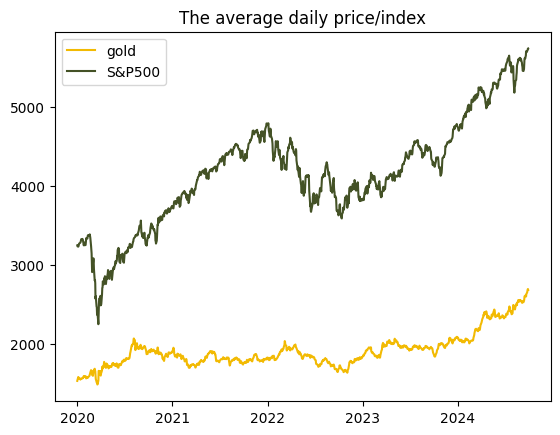

In [15]:
plt.plot(df.Date, df.gold, color='#F2BA03', label='gold')
plt.plot(df.Date, df.spx, color='#445226', label='S&P500')
# plt.plot(df.Date, df.eur, color='#334E7E', label='EURUSD')
# plt.plot(df.Date, df.jpy, color='#DE94C7', label='USDJPY')
plt.legend()
plt.title('The average daily price/index');

In [16]:
nyse_holidays = holidays.NYSE(years=[2020, 2021, 2022, 2023, 2024])
nyse_holidays = list(nyse_holidays.keys())

dates_H = pd.bdate_range(start='07-01-2024', end='09-27-2024',
                         freq=pd.tseries.offsets.CustomBusinessDay(holidays=nyse_holidays))
H = len(dates_H)
H

63

In [17]:
dates_H

DatetimeIndex(['2024-07-01', '2024-07-02', '2024-07-03', '2024-07-05',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-15', '2024-07-16', '2024-07-17',
               '2024-07-18', '2024-07-19', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-29',
               '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02',
               '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08',
               '2024-08-09', '2024-08-12', '2024-08-13', '2024-08-14',
               '2024-08-15', '2024-08-16', '2024-08-19', '2024-08-20',
               '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-26',
               '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-30',
               '2024-09-03', '2024-09-04', '2024-09-05', '2024-09-06',
               '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-12',
               '2024-09-13', '2024-09-16', '2024-09-17', '2024-09-18',
      

# NHITS

In [18]:
nhits_nearest = NHITS(h=H, input_size=3*H, hist_exog_list=['spx'], interpolation_mode='nearest',
                      windows_batch_size=3*H, start_padding_enabled=True, scaler_type='minmax')
nhits_linear = NHITS(h=H, input_size=3*H, hist_exog_list=['spx'], 
                     windows_batch_size=3*H, start_padding_enabled=True, scaler_type='minmax')
nhits_cubic = NHITS(h=H, input_size=3*H, hist_exog_list=['spx'], interpolation_mode='cubic', 
                    windows_batch_size=3*H, start_padding_enabled=True, scaler_type='minmax')
model = nf.NeuralForecast(models=[nhits_nearest, nhits_linear, nhits_cubic],
                          freq=pd.tseries.offsets.CustomBusinessDay(holidays=nyse_holidays))

In [19]:
model.fit(train_df, id_col='unique_id', time_col='Date', target_col='gold', verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [20]:
forecast = model.predict().reset_index()
forecast

/opt/conda/lib/python3.10/site-packages/utilsforecast/processing.py:392: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  out = times + n * freq
/opt/conda/lib/python3.10/site-packages/utilsforecast/processing.py:441: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  out.append([starts + i * freq])
/opt/conda/lib/python3.10/site-packages/utilsforecast/processing.py:441: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  out.append([starts + i * freq])
/opt/conda/lib/python3.10/site-packages/utilsforecast/processing.py:441: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  out.append([starts + i * freq])
/opt/conda/lib/python3.10/site-packages/utilsforecast/processing.py:441: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  out.append([starts + i * freq])
/opt/conda/lib/python3.10/site-pac

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,Date,NHITS,NHITS1,NHITS2
0,1,2024-07-01,2341.208496,2334.036621,2337.293457
1,1,2024-07-02,2344.630127,2329.332520,2331.434326
2,1,2024-07-03,2346.278809,2327.991699,2325.398438
3,1,2024-07-05,2341.481689,2330.289551,2315.587402
4,1,2024-07-08,2342.918701,2326.247070,2309.672363
...,...,...,...,...,...
58,1,2024-09-23,2356.516113,2329.687988,2306.383789
59,1,2024-09-24,2331.613770,2321.605469,2310.028564
60,1,2024-09-25,2338.226318,2316.795166,2309.640137
61,1,2024-09-26,2322.910156,2304.175781,2312.304688


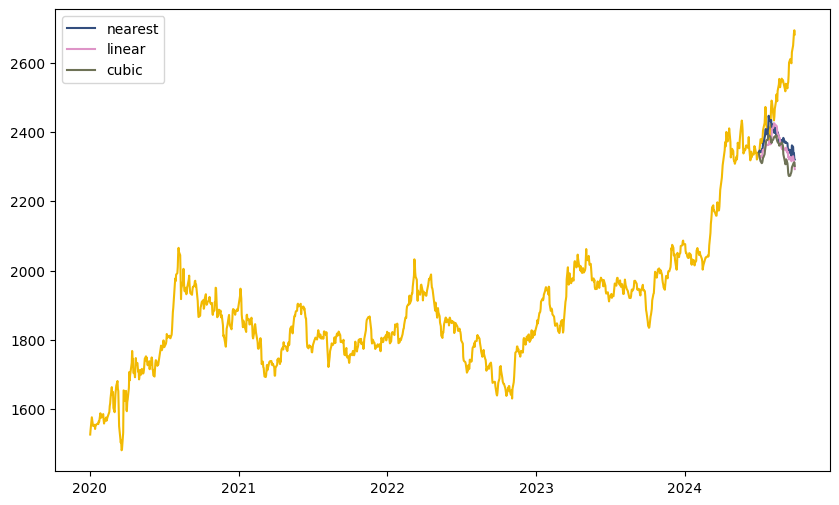

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df.Date, df.gold, color='#F2BA03')
plt.plot(forecast.Date, forecast.NHITS, label='nearest', color='#334E7E')
plt.plot(forecast.Date, forecast.NHITS1, label='linear', color='#DE94C7')
plt.plot(forecast.Date, forecast.NHITS2, label='cubic', color='#6E7256')
plt.legend();

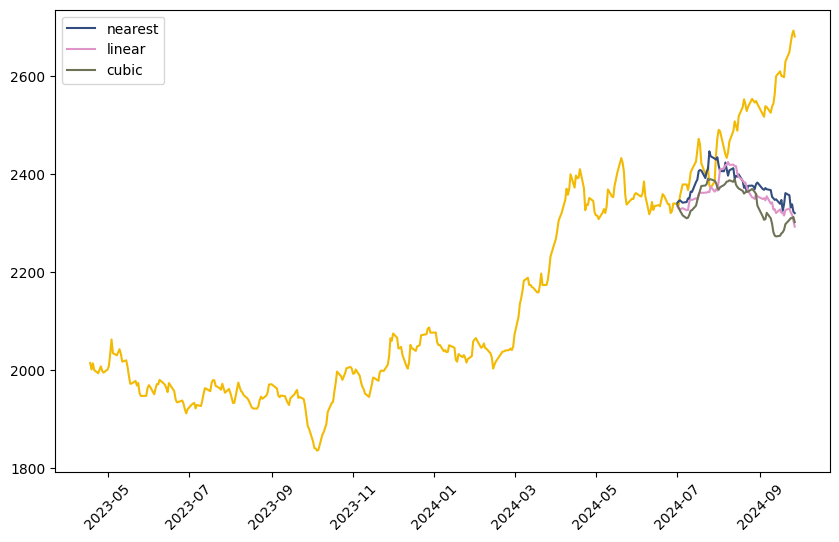

In [22]:
plt.figure(figsize=(10,6))
plt.plot(df.Date[-365:], df.gold[-365:], color='#F2BA03')
plt.plot(forecast.Date, forecast.NHITS, label='nearest', color='#334E7E')
plt.plot(forecast.Date, forecast.NHITS1, label ='linear', color='#DE94C7')
plt.plot(forecast.Date, forecast.NHITS2, label='cubic', color='#6E7256')
plt.legend()
plt.tick_params(axis='x', rotation=45);

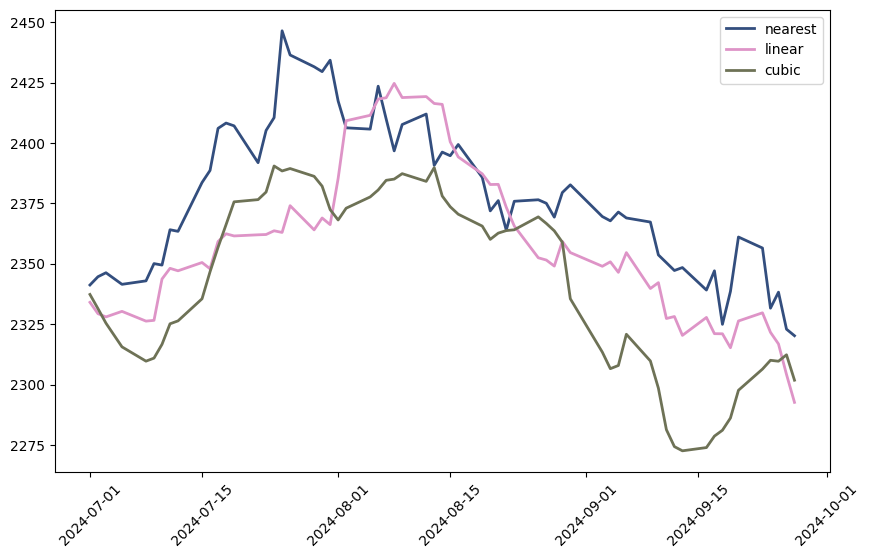

In [23]:
# only the forecasts
plt.figure(figsize=(10,6))
plt.plot(forecast.Date, forecast.NHITS, label='nearest', color='#334E7E', linewidth=2)
plt.plot(forecast.Date, forecast.NHITS1, label ='linear', color='#DE94C7', linewidth=2)
plt.plot(forecast.Date, forecast.NHITS2, label='cubic', color='#6E7256', linewidth=2)
plt.legend()
plt.tick_params(axis='x', rotation=45);

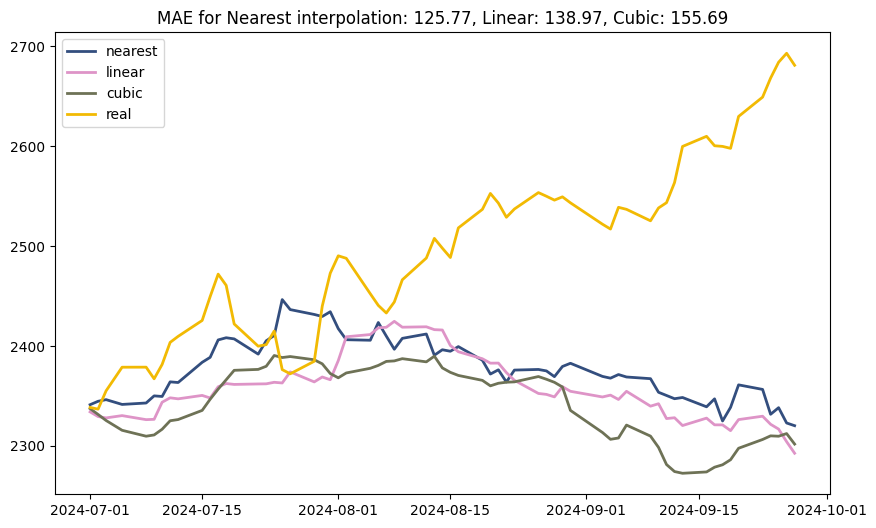

In [24]:
plt.figure(figsize=(10,6))
plt.plot(forecast.Date, forecast.NHITS, label='nearest', color='#334E7E', linewidth=2)
plt.plot(forecast.Date, forecast.NHITS1, label='linear', color='#DE94C7', linewidth=2)
plt.plot(forecast.Date, forecast.NHITS2, label='cubic', color='#6E7256', linewidth=2)
plt.plot(test_df.Date, test_df.gold, label='real', color='#F2BA03', linewidth=2)

real_value = test_df.gold.values
mae_nearest = np.round(np.mean(np.abs(forecast.NHITS.values-real_value)), 2)
mae_linear = np.round(np.mean(np.abs(forecast.NHITS1.values-real_value)), 2)
mae_cubic = np.round(np.mean(np.abs(forecast.NHITS2-real_value)), 2)
plt.title(f'MAE for Nearest interpolation: {mae_nearest}, Linear: {mae_linear}, Cubic: {mae_cubic}')
plt.legend();